In [1]:
import pandas as pd
from pathlib import Path
from torch_geometric.data import download_url, extract_zip

In [2]:
from dataclasses import dataclass


@dataclass(frozen=True)
class FileArtifact:
    url: str
    path: Path
    force_download: bool = False

    def __post_init__(self):
        if self.path.exists() and not self.force_download:
            print(f"Using cached file '{self.path}'")
            return
        if not self.path.parent.exists():
            print(f"Creating directory '{self.path.parent}'")
            self.path.parent.mkdir(parents=True)
        print(f"Downloading file from '{self.url}' to '{self.path}'")
        download_url(self.url, self.path.parent, filename=self.file.name, log=False)

    def __repr__(self) -> str:
        return f"File from '{self.url}' is at path '{self.path}'"

    def __str__(self) -> str:
        return f"{self.path}"


@dataclass(frozen=True)
class ZipArtifact:
    url: str
    extract_at: Path
    expected_content: list[str]
    remove_zip: bool = False

    def __post_init__(self):
        if not self.extract_at.exists():
            print(f"Creating directory '{self.extract_at}'")
            self.extract_at.mkdir(parents=True)
        expected_content_exists = all(
            (self.extract_at / name).exists() for name in self.expected_content
        )
        if expected_content_exists:
            print(
                f"Using cached files from '{self.url}' extracted to '{self.extract_at}'"
            )
            return
        print(f"Downloading zip file from '{self.url}' to '{self.extract_at}'")
        path_to_zip = download_url(self.url, self.extract_at.parent, log=False)
        extract_zip(path_to_zip, self.extract_at, log=False)
        expected_content = set(self.expected_content)
        for new_file in self.extract_at.iterdir():
            if new_file.name in expected_content:
                expected_content.remove(new_file.name)
                continue
            print(f"Warning: got unexpected file '{new_file}'")
        if expected_content:
            print(f"Warning: missing expected files {expected_content}")
        if self.remove_zip:
            Path(path_to_zip).unlink()

    @property
    def path(self):
        return self.extract_at

    @property
    def contents(self) -> list[Path]:
        return [self.extract_at / name for name in self.expected_content]

In [3]:
HERE = Path(".")
ROOT = Path("..")


residue_atom_index_artifact = ZipArtifact(
    "https://www.dropbox.com/scl/fi/cj2801jszmj73cmhklycx/residue_atom_index.zip?rlkey=i5qzddjcb4jcbao19h6jgfx00&st=go9ujwsg&dl=1",
    ROOT / "data" / "processed",
    expected_content=["residue_atom_index"],
)


mask_pl_edge_residue_results_artifact = ZipArtifact(
    "https://www.dropbox.com/scl/fi/2vt532fkofgdth2ae6c19/mask_pl_edges_at_residue.zip?rlkey=1z14ykkh8fn5lvwafc17b2gef&st=zqe0osr0&dl=1",
    ROOT / "data" / "crocodoc",
    expected_content=["mask_pl_edges_at_residue"],
)

Creating directory '../data/crocodoc'


In [4]:
# TODO
# - add PLIP artifact
# - add kinodata 3D raw and processed artifact?

## Data loading 1: crocodoc output data pl edge masking at residues

In [5]:
mask_pl_edge_residue_result = mask_pl_edge_residue_results_artifact.contents[0]

In [6]:
# count number of csv files in source dir
print(len(list(mask_pl_edge_residue_result.glob("*.csv"))))

945


In [7]:
ref_dfs = []
attr_dfs = []
for csv_file in mask_pl_edge_residue_result.glob("*.csv"):
    if "None" in csv_file.name:
        continue
    print(csv_file.name)
    df = pd.read_csv(csv_file)
    if "cgnn3d" in csv_file.name:
        model = "CGNN-3D"
    elif "cgnn" in csv_file.name:
        model = "CGNN"
    else:
        model = None
    df["model"] = model
    if "reference" in csv_file.stem:
        ref_dfs.append(df)
        continue
    attr_dfs.append(df)

residue_delta_scaffold_0_cgnn_part_9.csv
residue_delta_scaffold_3_cgnn3d_part_84.csv
residue_delta_scaffold_0_cgnn3d_part_5.csv
residue_delta_scaffold_3_cgnn3d_part_53.csv
residue_delta_scaffold_1_cgnn3d_part_3.csv
residue_delta_scaffold_3_cgnn3d_part_47.csv
residue_delta_scaffold_4_cgnn3d_part_13.csv
residue_delta_scaffold_4_cgnn_part_50.csv
residue_delta_scaffold_1_cgnn3d_part_59.csv
residue_delta_scaffold_4_cgnn_part_44.csv
reference_scaffold_2_cgnn3d.csv
residue_delta_scaffold_1_cgnn3d_part_71.csv
residue_delta_scaffold_1_cgnn3d_part_65.csv
residue_delta_scaffold_4_cgnn_part_78.csv
residue_delta_scaffold_4_cgnn3d_part_0.csv
residue_delta_scaffold_0_cgnn3d_part_57.csv
residue_delta_scaffold_2_cgnn_part_14.csv
residue_delta_scaffold_0_cgnn3d_part_43.csv
residue_delta_scaffold_2_cgnn_part_28.csv
residue_delta_scaffold_3_cgnn_part_62.csv
residue_delta_scaffold_3_cgnn_part_76.csv
residue_delta_scaffold_0_cgnn3d_part_80.csv
residue_delta_scaffold_0_cgnn_part_40.csv
residue_delta_scaffold

In [8]:
attr_df = pd.concat(attr_dfs, axis=0)
ref = pd.concat(ref_dfs, axis=0)

In [9]:
attr_df.head()

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model
0,23315,6280856,3038,25,8.400028,GLY,G,CGNN
1,2099,747076,786,25,8.979584,ALA,A,CGNN
2,2803,1001015,14527,25,7.473264,ALA,A,CGNN
3,31318,12158574,1065,25,7.979068,ALA,A,CGNN
4,70124,17663250,6057,25,8.870531,ALA,A,CGNN


In [10]:
ref.head()

,ident,chembl_activity_id,klifs_structure_id,reference_pred,target,model
0,25977,7978870,786,5.954986,5.728158,CGNN-3D
1,65458,17633685,6057,6.753573,6.801343,CGNN-3D
2,47959,16312065,1415,8.294194,9.000000,CGNN-3D
3,70955,17670665,14978,7.218015,6.210419,CGNN-3D
4,40021,15061108,7177,6.884452,6.769551,CGNN-3D


In [11]:
attr_df = pd.merge(
    attr_df,
    ref[["chembl_activity_id", "reference_pred", "target", "model"]],
    on=["chembl_activity_id", "model"],
    how="left",
)

In [12]:
attr_df["delta"] = attr_df["reference_pred"] - attr_df["masked_pred"]

In [13]:
attr_df.head()

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta
0,23315,6280856,3038,25,8.400028,GLY,G,CGNN,8.400028,8.553953,0.000000
1,2099,747076,786,25,8.979584,ALA,A,CGNN,8.979579,8.920819,-0.000005
2,2803,1001015,14527,25,7.473264,ALA,A,CGNN,7.473276,6.892790,0.000012
3,31318,12158574,1065,25,7.979068,ALA,A,CGNN,7.979075,7.847712,0.000007
4,70124,17663250,6057,25,8.870531,ALA,A,CGNN,8.870525,8.420216,-0.000006


### Sanity check deltas for cgnn are close to zero

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

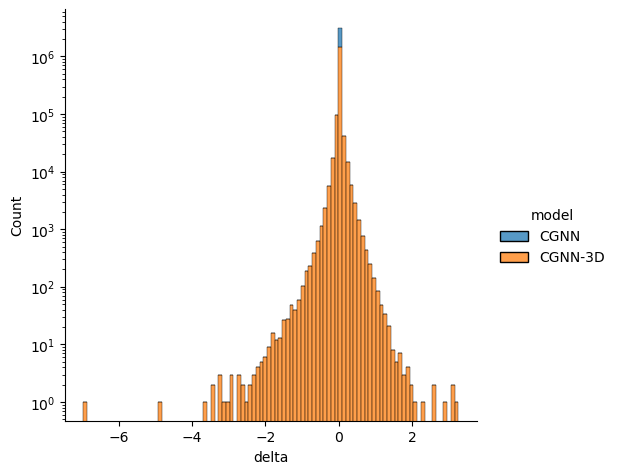

In [15]:
grid = sns.displot(
    attr_df,
    x="delta",
    kind="hist",
    bins=100,
    hue="model",
    multiple="stack",
)
grid.ax.set_yscale("log")

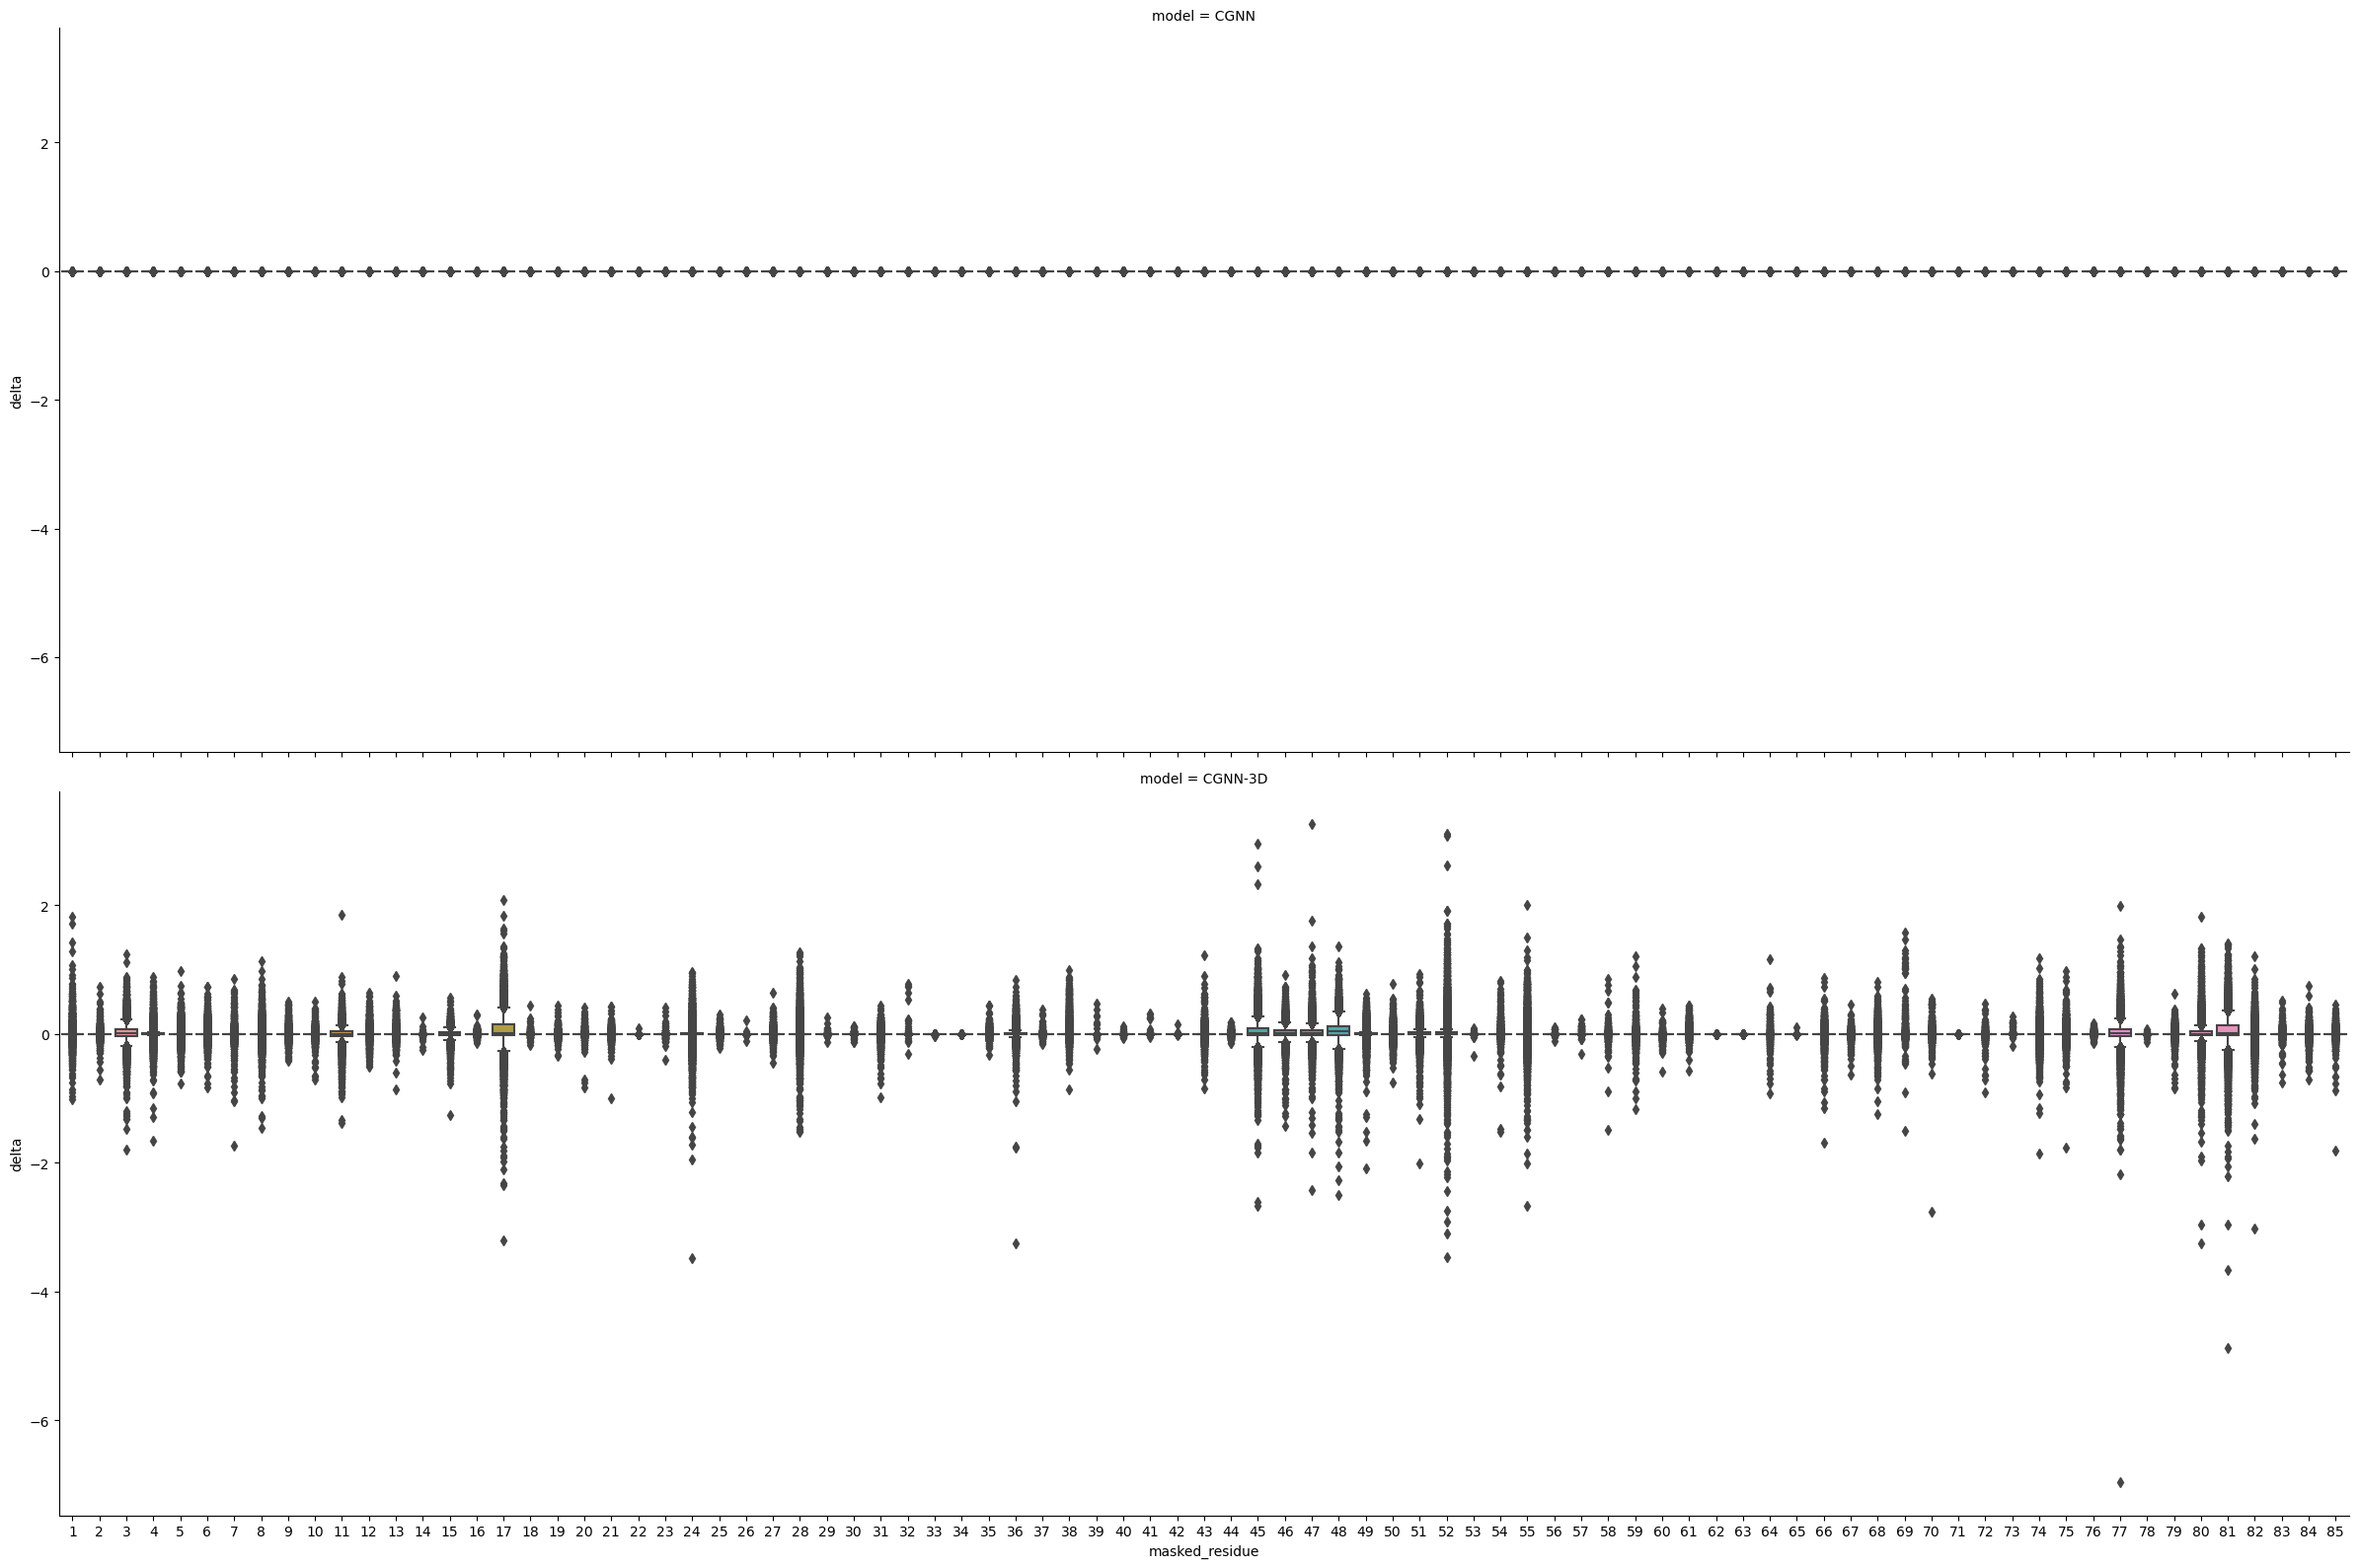

In [16]:
sns.catplot(
    attr_df,
    y="delta",
    x="masked_residue",
    kind="box",
    row="model",
    aspect=3,
    height=8,
    orient="v",
)

In [17]:
def make_var_plot(df):
    delta_var = (
        df.groupby("masked_residue")["delta"].agg("var").to_frame().reset_index()
    )
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.barplot(delta_var, x="masked_residue", y="delta", ax=ax)
    # rotate x labels
    plt.xticks(rotation=90)

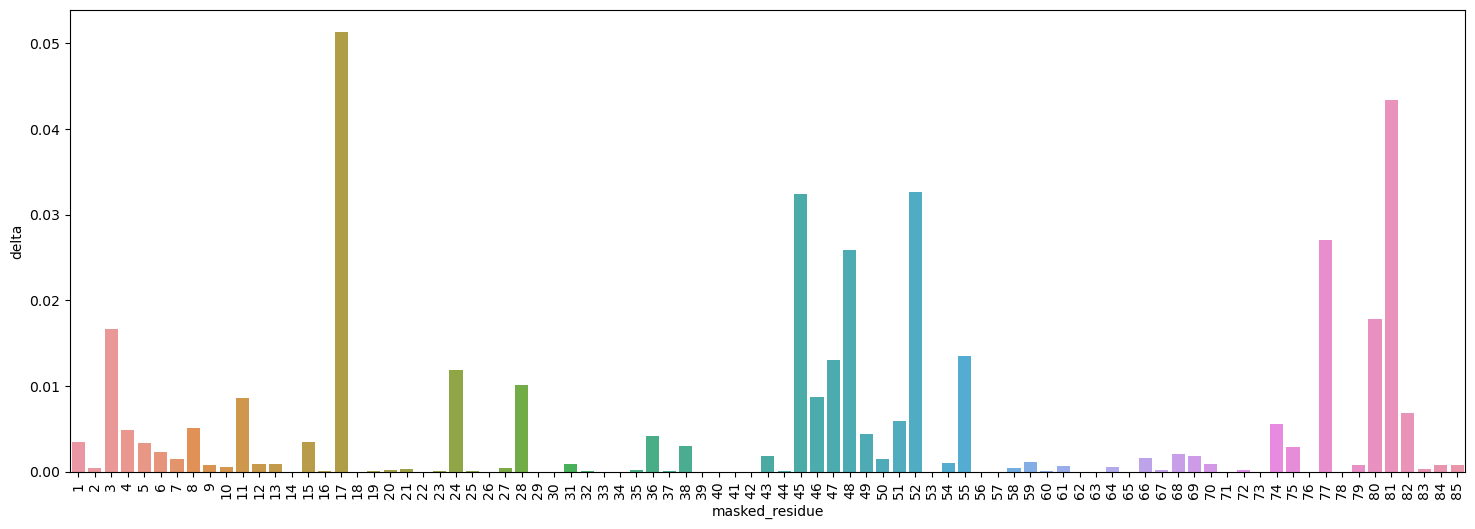

In [18]:
cgnn3d_only = attr_df[attr_df["model"] == "CGNN-3D"]
cgnn_only = attr_df[attr_df["model"] == "CGNN"]
make_var_plot(cgnn3d_only)

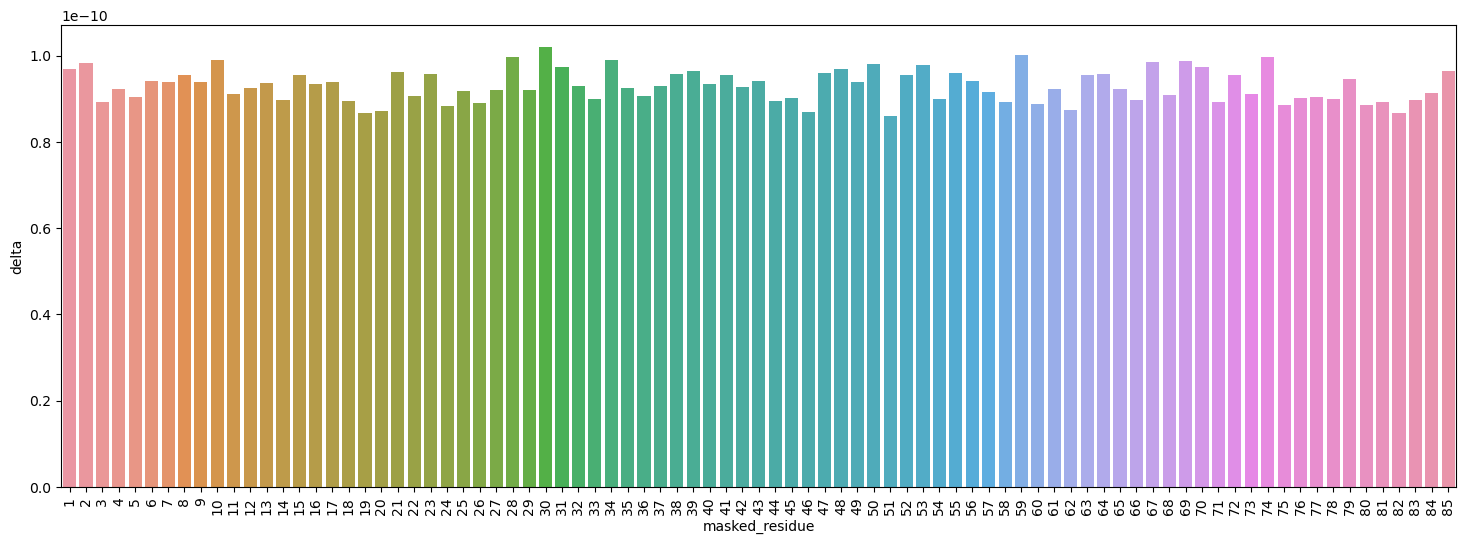

In [19]:
make_var_plot(cgnn_only)

In [25]:
meta_data = pd.read_csv("../data/processed/kinodata_docked.csv")
meta_data.set_index("activities.activity_id", inplace=True)
meta_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/kinodata_docked.csv'

## Data loading 2
- residue atom index (ie Map[ident, Map[residue id, pocket atom index of atoms in that residue]])
- Kinodata3D pytorch geometric data objects
- Kinodata3D underlying rdkit mols

In [27]:
from kinodata.data import KinodataDocked
from kinodata.data.dataset import _DATA
from pathlib import Path
from kinodata.transform import TransformToComplexGraph
from tqdm import tqdm
import multiprocessing as mp
import json
from rdkit import Chem
from rdkit.Chem import Draw
import random


RESIDUE_ATOM_INDEX = residue_atom_index_artifact.contents[0]

to_cplx = TransformToComplexGraph()


def get_ident(file: Path):
    ident = int(file.stem.split("_")[-1])
    return ident


def load_single_index(file: Path):
    with open(file, "r") as f:
        try:
            dictionary = json.load(f)
        except json.decoder.JSONDecodeError:
            dictionary = None
    ident = int(file.stem.split("_")[-1])
    return (ident, dictionary)


def load_residue_atom_index(idents, parallelize=False):
    files = list(RESIDUE_ATOM_INDEX.iterdir())
    files = [file for file in files if get_ident(file) in idents]
    assert len(files) == len(idents)
    progressing_iterable = tqdm(files, desc="Loading residue atom index...")
    if parallelize:
        with mp.Pool() as pool:
            tuples = pool.map(load_single_index, progressing_iterable)
    else:
        tuples = [load_single_index(f) for f in progressing_iterable]
    return dict(tuples)

In [28]:
dataset = KinodataDocked()

In [29]:
data_by_ident = {data.ident.item(): data for data in dataset}

In [30]:
mol_source_df = dataset.df

Reading data frame from /home/michael/Code/kinodata-3D-affinity-prediction/data/raw/kinodata_docked_v2.sdf.gz...
Deduping data frame (current size: 872)...
865 complexes remain after deduplication.
Checking for missing pocket mol2 files...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 6195.00it/s]


Adding pocket sequences...
(865, 25)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 865/865 [00:00<00:00, 1159499.19it/s]

Exiting with 3552 cached sequences.
(865, 26)


In [31]:
mol_source_df.columns

Index(['docking.posit_probability', 'docking.chemgauss_score',
       'activities.activity_id', 'assays.chembl_id',
       'target_dictionary.chembl_id', 'molecule_dictionary.chembl_id',
       'molecule_dictionary.max_phase', 'activities.standard_type',
       'activities.standard_units', 'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID', 'similar.klifs_structure_id',
       'similar.fp_similarity', 'ID', 'activities.standard_value',
       'docking.predicted_rmsd', 'molecule', 'pocket_mol2_file', 'ident',
       'structure.pocket_sequence'],
      dtype='object')

In [32]:
mols_by_ident = mol_source_df.set_index("ident")

In [33]:
mol_source_df["activities.activity_id"] = mol_source_df[
    "activities.activity_id"
].astype(int)

In [34]:
mols_by_chembl_id = mol_source_df.set_index("activities.activity_id")

### Add min distance ligand to residue

# TODO

In [29]:
# TODO

## Data loading 3: PLIP interaction data

# TODO

In [30]:
# TODO
# add plip and #plip columns to attr_df

## Data analysis 1: single complex delta analysis

Select a single complex and make select the data that corresponds to that complex.

In [316]:
import random

# set chembl activity id here, ...
# choice = 2390222
# choice = 3559317
choice = None

if choice:
    subs = cgnn3d_only[cgnn3d_only["chembl_activity_id"] == choice]
    ident = subs["ident"].iloc[0]
    chembl_activity_id = choice
# or pick a random one
else:
    ident, index = random.choice(list(cgnn3d_only.groupby("ident").groups.items()))
    ra = load_residue_atom_index([ident])[ident]
    ra = {int(k): v for k, v in ra.items()}
    subs = cgnn3d_only.loc[index]
    chembl_activity_id = subs["chembl_activity_id"].iloc[0]

assert subs["chembl_activity_id"].nunique() == 1
assert subs["ident"].nunique() == 1

print(f"Selected activity {chembl_activity_id} with ident {ident}")
subs["abs_delta"] = np.abs(subs["delta"])
# subs = subs.nlargest(10, "abs_delta")
subs

Loading residue atom index...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.44it/s]

Selected activity 12662130 with ident 32688


,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta,abs_delta
97184,32688,12662130,1913,44,7.042261,VAL,V,CGNN-3D,7.042262,7.337242,1.000000e-06,1.000000e-06
108024,32688,12662130,1913,21,7.042263,THR,T,CGNN-3D,7.042262,7.337242,-1.000000e-06,1.000000e-06
115958,32688,12662130,1913,20,7.042267,HIS,H,CGNN-3D,7.042262,7.337242,-5.000000e-06,5.000000e-06
119979,32688,12662130,1913,68,7.042265,TYR,Y,CGNN-3D,7.042262,7.337242,-3.400000e-06,3.400000e-06
127913,32688,12662130,1913,69,7.042265,ARG,R,CGNN-3D,7.042262,7.337242,-3.000000e-06,3.000000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
3204741,32688,12662130,1913,14,7.042267,TYR,Y,CGNN-3D,7.042262,7.337242,-5.000000e-06,5.000000e-06
3208762,32688,12662130,1913,84,7.042267,LEU,L,CGNN-3D,7.042262,7.337242,-5.000000e-06,5.000000e-06
3220609,32688,12662130,1913,41,7.042267,ALA,A,CGNN-3D,7.042262,7.337242,-5.300000e-06,5.300000e-06
3224630,32688,12662130,1913,67,7.042263,VAL,V,CGNN-3D,7.042262,7.337242,-6.000000e-07,6.000000e-07


In [317]:
from kinodata.data.io.read_klifs_mol2 import read_klifs_mol2

klifs_id = subs["klifs_structure_id"].unique()[0]
pocket_file = Path(f"../data/raw/mol2/pocket/{klifs_id}_pocket.mol2")
pocket_file.exists()
mol2_meta = read_klifs_mol2(pocket_file, with_bonds=False)
mol2_meta = mol2_meta[["residue.subst_id", "residue.subst_name"]].drop_duplicates()
mask_to_weird = dict(zip(subs['masked_residue'].unique(), sorted(mol2_meta['residue.subst_name'].str[3:].astype(int))))
subs["residue.subst_id"] = subs["masked_residue"].apply(lambda x: mask_to_weird[x])
subs_with_mol2 = pd.merge(subs, mol2_meta, on="residue.subst_id", how="left")

#### Plot 

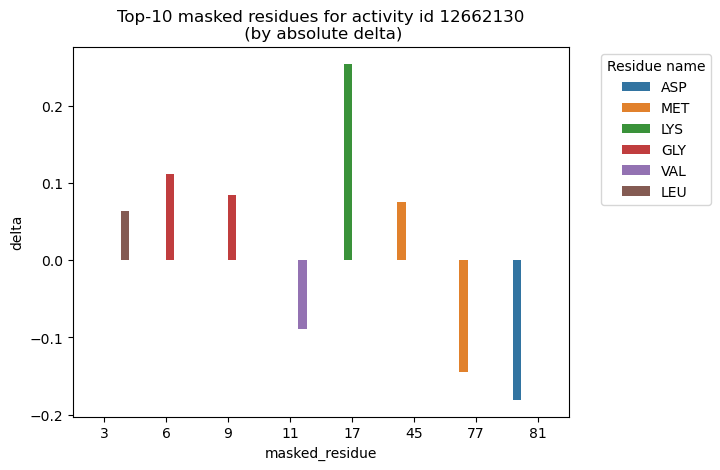

In [318]:
chembl_id = subs["chembl_activity_id"].iloc[0]
ax = sns.barplot(
    subs[subs.delta.abs() > .05],
    x="masked_residue",
    y="delta",
    hue="masked_resname",
)
_ = ax.set_title(
    f"Top-10 masked residues for activity id {chembl_id}\n (by absolute delta)"
)
# move legend outside of plot
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1), title="Residue name")

In [319]:
# get diverging color map
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=min(subs["delta"]), vmax=max(subs["delta"]))
cmap = cm.get_cmap("bwr")
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)


def map_to_hex(val):
    max_val = subs['delta'].abs().max()
    rgba = cmapper.to_rgba(val / max_val)
    hex_color = f"#{''.join(f'{int(255 * x):02x}' for x in rgba[:3])}"
    return hex_color

subs_with_mol2["colorcode"] = subs_with_mol2["delta"].apply(map_to_hex)

In [320]:
@dataclass
class ColorCommand:
    colorcode: str
    residue_index: int

    def __str__(self):
        return f"color :{self.residue_index} {self.colorcode}"

In [321]:
def write(
    commands: list[ColorCommand],
    file: Path,
):
    content = "\n".join(str(command) for command in commands)
    file.write_text(content)
    return content

In [322]:
import requests as req


for struc in 'ligand pocket'.split():
    resp = req.get(f'https://klifs.net/api/structure_get_{struc}?structure_ID={klifs_id}')
    
    with open(f"/home/michael/{struc}.mol2", 'wb') as f:
        f.write(resp.content)

In [323]:
with open('/home/michael/amazing.cxc', 'w') as f:
    f.write("""close session
open ~/ligand.mol2
open ~/pocket.mol2
""")
    f.write('\n'.join([f'color :{ident} {c}' for c, ident in subs_with_mol2[['colorcode', 'residue.subst_id']].values]))